# What makes Time Series Special?

As the name suggests, TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

+ It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
+ Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.


# Loading and Handling Time Series in Pandas

Pandas has dedicated libraries for handling TS objects, particularly the datatime64[ns] class which stores time information and allows us to perform some operations really fast. Lets start by firing up the required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

Now, we can load the data set and look at some initial rows and data types of the columns:

In [2]:
data = pd.read_csv('AirPassengers.csv')
print data.head()
print '\n Data Types:'
print data.dtypes

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121

 Data Types:
Month          object
#Passengers     int64
dtype: object


The data contains a particular month and number of passengers travelling in that month. But this is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command:

In [9]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


Let’s understand the arguments one by one:

    parse_dates: This specifies the column which contains the date-time information. As we say above, the column name is ‘Month’.
    index_col: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.
    date_parser: This specifies a function which converts an input string into datetime variable. Be default Pandas reads data in format ‘YYYY-MM-DD HH:MM:SS’. If the data is not in this format, the format has to be manually defined. Something similar to the dataparse function defined here can be used for this purpose.

Now we can see that the data has time object as index and #Passengers as the column. We can cross-check the datatype of the index with the following command:

In [10]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

Notice the dtype=’datetime[ns]’ which confirms that it is a datetime object. As a personal preference, I would convert the column into a Series object to prevent referring to columns names every time I use the TS. Please feel free to use as a dataframe is that works better for you.

In [12]:
ts = data['#Passengers'] 
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

Before going further, I’ll discuss some indexing techniques for TS data. Lets start by selecting a particular value in the Series object. This can be done in following 2 ways:

In [14]:
#1. From above, specific the index as a string constant:
print ts['1949-01-01']

#2. Import the datetime library and use 'datetime' function:
from datetime import datetime
print ts[datetime(1949,1,1)]

112
112


Both would return the value ‘112’ which can also be confirmed from previous output. Suppose we want all the data upto May 1949. This can be done in 2 ways:

In [16]:
#1. Specify the entire range:
print ts['1949-01-01':'1949-05-01']

#2. Use ':' if one of the indices is at ends:
print ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


Both would yield the same output

There are 2 things to note here:

+ Unlike numeric indexing, the **end index is included here**. For instance, if we index a list as a[:5] then it would return the values at indices – [0,1,2,3,4]. But here the index ‘1949-05-01’ was included in the output.
+ The **indices have to be sorted** for ranges to work. If you randomly shuffle the index, this won’t work.

Consider another instance where you need all the values of the year 1949. This can be done as:

In [17]:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

The month part was omitted. Similarly if you all days of a particular month, the day part can be omitted.

Now, lets move onto the analyzing the TS.

# How to Check Stationarity of a Time Series?

A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

+ constant mean
+ constant variance
+ an autocovariance that does not depend on time.

Lets move onto the ways of testing stationarity. First and foremost is to simple plot the data and analyze visually. The data can be plotted using following command:

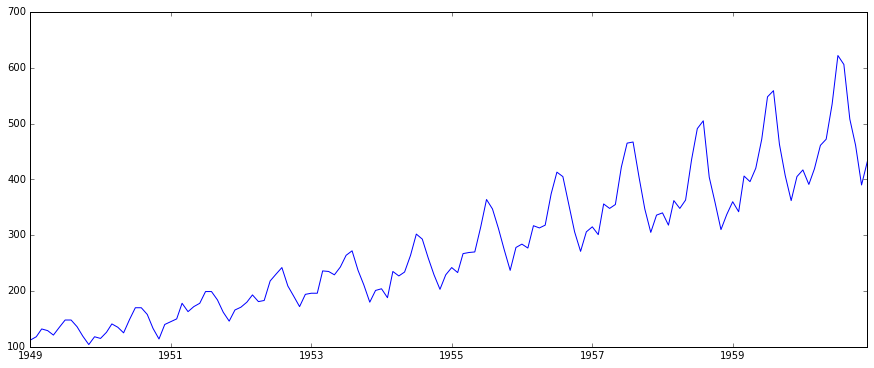

In [18]:
plt.plot(ts)

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences (we’ll see such cases later). So, more formally, we can check stationarity using the following:

+ Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
+ Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 